## Identificação de Empresas Fantasmas

**Carregamento dos dados**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Listando imagens de empresas

In [ ]:
!ls -1 '/content/gdrive/MyDrive/Dados_ProjetoFinal_MDC010-INF019/raw/imagens_empresas' | wc -l 

4547


Listando imagens de não-empresas

In [ ]:
!ls -1 '/content/gdrive/MyDrive/Dados_ProjetoFinal_MDC010-INF019/raw/imagens_nao_empresas' | wc -l 

6457


**Separando imagens (treino, validação e teste)**

In [ ]:
#!pip install split-folders
#import splitfolders

In [ ]:
#input_folder = '/content/gdrive/MyDrive/Dados_ProjetoFinal_MDC010-INF019/raw'
#output = '/content/gdrive/MyDrive/Dados_ProjetoFinal_MDC010-INF019/split_train_val_test/'

In [ ]:
#splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.6, .2, .2)) #ratio(train/val/test)

Checagem dos dados

In [ ]:
#!find '/content/gdrive/MyDrive/Dados_ProjetoFinal_MDC010-INF019/split_train_val_test/' -type f -print > lista_arquivos_trabalho_final.txt

**Análise Exploratória**

In [ ]:
!pip install dask[bag]

import os
import matplotlib.pyplot as plt
import pandas as pd
from dask import bag, diagnostics
from PIL import Image
import numpy as np

In [ ]:
nao_empresa = '/content/gdrive/MyDrive/Dados_ProjetoFinal_MDC010-INF019/raw/imagens_nao_empresas/'
empresa = '/content/gdrive/MyDrive/Dados_ProjetoFinal_MDC010-INF019/raw/imagens_empresas/'


df_classes = pd.DataFrame([{'Classe': 'Não Empresas', '#': len(os.listdir(nao_empresa))},
                           {'Classe': 'Empresas', '#': len(os.listdir(empresa))}])

df_classes['%'] = (df_classes['#'] / df_classes['#'].sum()) * 100
df_classes

,Classe,#,%
0,Não Empresas,6457,58.678662
1,Empresas,4547,41.321338


Basic Image EDA

In [ ]:
# https://pypi.org/project/basic-image-eda/
!pip install basic-image-eda
from basic_image_eda import BasicImageEDA

#Options:
#  -e --extensions          target image extensions. if none, all supported extensions are included.(default=None)
#  -t --threads             number of multiprocessing threads. if 0, automatically count max threads.(default=0)
#  -d --dimension_plot      show dimension(height/width) scatter plot.(default=False)
#  -c --channel_hist        show channelwise pixel value histogram. takes longer time.(default=False)
#  -n --nonzero             calculate values only from non-zero pixels of the images.(default=False)
#  -f --hw_division_factor  divide height,width of the images by this factor to make pixel value calculation faster.
#                           Information on height, width are not changed and will be printed correctly.(default=1.0)
#  -V --version             show version.

Não Empresa


found 6457 images.
Using 2 threads. (max:2)



100%|██████████| 6457/6457 [03:55<00:00, 27.37it/s]



*--------------------------------------------------------------------------------------*
number of images                         |  6457

dtype                                    |  uint8
channels                                 |  [3]
extensions                               |  ['jpg']

min height                               |  500
max height                               |  500
mean height                              |  500.0
median height                            |  500

min width                                |  640
max width                                |  640
mean width                               |  640.0
median width                             |  640

mean height/width ratio                  |  0.78125
median height/width ratio                |  0.78125
recommended input size(by mean)          |  [496 640] (h x w, multiples of 8)
recommended input size(by mean)          |  [496 640] (h x w, multiples of 16)
recommended input size(by mean)          |  [512 640] (h x

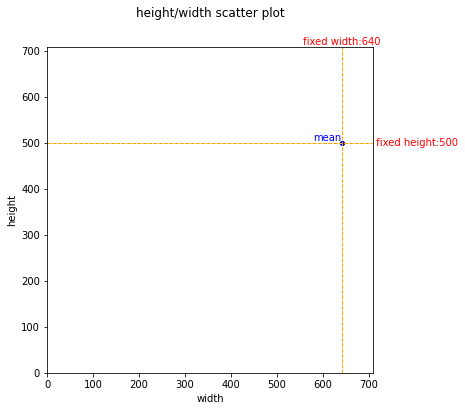

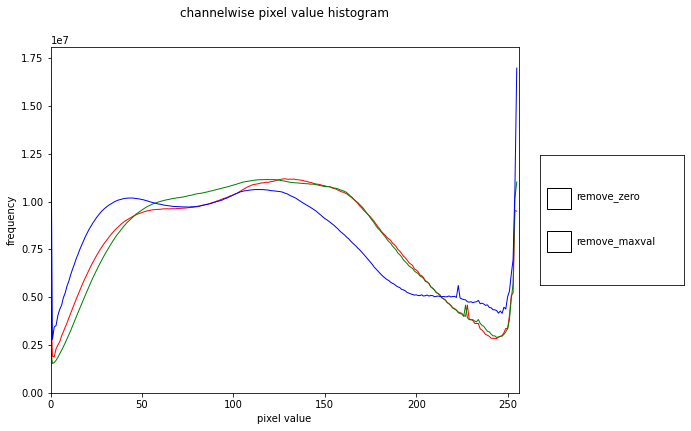

In [ ]:
data_dir = nao_empresa
extensions = ['png', 'jpg', 'jpeg']
threads = 0
dimension_plot = True
channel_hist = True
nonzero = False
hw_division_factor = 1.0

results_nao_empresa = BasicImageEDA.explore(data_dir, extensions, threads, dimension_plot, channel_hist, nonzero, hw_division_factor)

Empresa


found 4547 images.
Using 2 threads. (max:2)



100%|██████████| 4547/4547 [10:00<00:00,  7.58it/s]



*--------------------------------------------------------------------------------------*
number of images                         |  4547

dtype                                    |  uint8
channels                                 |  [3]
extensions                               |  ['jpg']

min height                               |  500
max height                               |  500
mean height                              |  500.0
median height                            |  500

min width                                |  640
max width                                |  640
mean width                               |  640.0
median width                             |  640

mean height/width ratio                  |  0.78125
median height/width ratio                |  0.78125
recommended input size(by mean)          |  [496 640] (h x w, multiples of 8)
recommended input size(by mean)          |  [496 640] (h x w, multiples of 16)
recommended input size(by mean)          |  [512 640] (h x

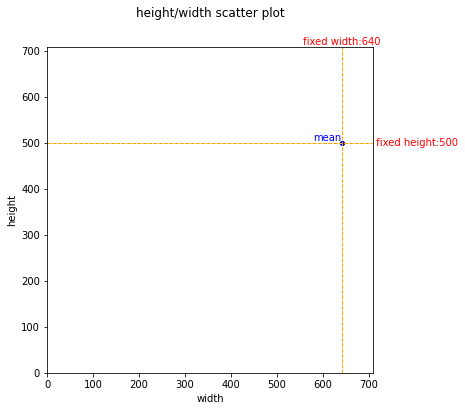

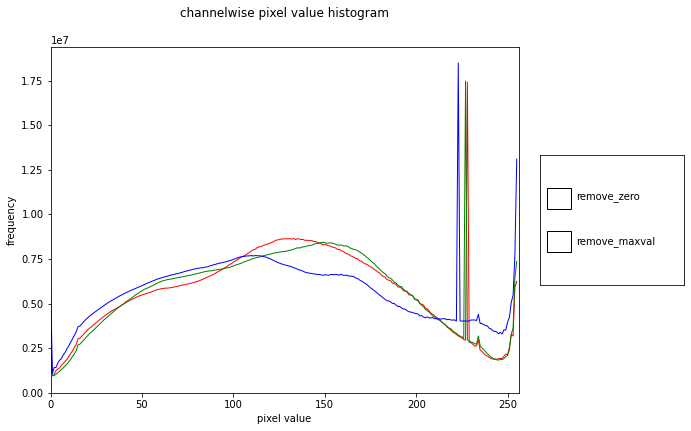

In [ ]:
data_dir = empresa
extensions = ['png', 'jpg', 'jpeg']
threads = 0
dimension_plot = True
channel_hist = True
nonzero = False
hw_division_factor = 1.0

results_empresa = BasicImageEDA.explore(data_dir, extensions, threads, dimension_plot, channel_hist, nonzero, hw_division_factor)

Conclusões:

- As imagens para ambas as classes possuem o mesmo tamanho, width=640 e height=500
- Convertemos as imagens em 3 canais (RBG) e analisamos a distribuição dos pixels. Através dos histogramas, identificamos a presença de ruídos na base.



**Criando dataframe RGB e target**

In [ ]:
import cv2
import numpy as np
import os
from tabulate import tabulate
import seaborn as sns

In [ ]:
def getFeatures(path, target):

  images = os.listdir(path)
  num_images = len(images)

  data = [] # using an array is more convenient for tabulate.
  data_to_print = []

  for i in range(num_images):
      img = cv2.imread(empresa + images[i])

      try:  
        avgR = np.mean(img[:,:,2])
        avgG = np.mean(img[:,:,1])
        avgB = np.mean(img[:,:,0])

        stdR = np.std(img[:,:,2])
        stdG = np.std(img[:,:,1])
        stdB = np.std(img[:,:,0])

        sumR = np.sum(img[:,:,2])
        sumG = np.sum(img[:,:,1])
        sumB = np.sum(img[:,:,0])

        maxR = np.max(img[:,:,2])
        maxG = np.max(img[:,:,1])
        maxB = np.max(img[:,:,0])

        minR = np.min(img[:,:,2])
        minG = np.min(img[:,:,1])
        minB = np.min(img[:,:,0])

      except:
        avgR = avgG = avgB = stdR = stdG = stdB = sumR = sumG = sumB = maxR = maxG = maxB = minR = minG = minB = None

      data.append({'img_name':images[i], 'target':target, 'avgR':avgR, 'avgG':avgG, 'avgB':avgB, 'stdR':stdR, 'stdG':stdG, 'stdB':stdB, 'sumR':sumR, 'sumG':sumG, 'sumB':sumB,
                   'maxR':maxR, 'maxG':maxG, 'maxB':maxB, 'minR':minR, 'minG':minG, 'minB':minB})

      data_to_print.append({images[i], target, avgR, avgG, avgB, stdR, stdG, stdB, sumR, sumG, sumB, maxR, maxG, maxB, minR, minG, minB})

  return data, data_to_print

In [ ]:
# Empresa = 1
# Nao Empresa = 0
#print(tabulate(empresa_features, headers=['img_name', 'target', 'avgR','avgG','avgB','stdR','stdG','stdB','sumR','sumG','sumB'], tablefmt='fancy_grid'))

empresa_features, empresa_print_features = getFeatures('/content/gdrive/MyDrive/Dados_ProjetoFinal_MDC010-INF019/raw/imagens_empresas', 1)
nao_empresa_features, empresa_print_features = getFeatures('/content/gdrive/MyDrive/Dados_ProjetoFinal_MDC010-INF019/raw/imagens_nao_empresas', 0)

In [ ]:
df_empresas_features = pd.DataFrame(empresa_features)
df_nao_empresas_features = pd.DataFrame(nao_empresa_features)

df_empresas_features.shape, df_nao_empresas_features.shape

((4547, 17), (6457, 17))

In [ ]:
df_final = pd.concat([df_empresas_features, df_nao_empresas_features])
df_final.to_csv('/content/gdrive/MyDrive/Dados_ProjetoFinal_MDC010-INF019/raw/eda_rgb_features.csv', index=False)

Carregando rgb_features.csv

In [81]:
import pandas as pd
import seaborn as sns

df_final = pd.read_csv('/content/gdrive/MyDrive/Dados_ProjetoFinal_MDC010-INF019/raw/eda_rgb_features.csv')
df_final.shape

(11004, 17)

In [82]:
df_final.head()

,img_name,target,avgR,avgG,avgB,stdR,stdG,stdB,sumR,sumG,sumB,maxR,maxG,maxB,minR,minG,minB
0,2437.jpg,1,96.109437,96.613125,94.967666,53.869693,49.745196,49.751794,30755020.0,30916200.0,30389653.0,254.0,255.0,255.0,0.0,0.0,0.0
1,2526.jpg,1,117.473856,119.592438,115.865184,54.478051,52.523485,55.112070,37591634.0,38269580.0,37076859.0,255.0,255.0,255.0,0.0,0.0,0.0
2,2491.jpg,1,121.385284,120.914941,116.869209,64.876546,63.988969,65.844986,38843291.0,38692781.0,37398147.0,255.0,255.0,255.0,0.0,0.0,0.0
3,2454.jpg,1,158.935472,162.215316,164.885925,63.626466,70.070700,73.434152,50859351.0,51908901.0,52763496.0,255.0,255.0,255.0,0.0,0.0,0.0
4,2517.jpg,1,115.398347,107.479691,93.070041,46.865500,46.433931,48.882044,36927471.0,34393501.0,29782413.0,255.0,255.0,255.0,0.0,0.0,0.0


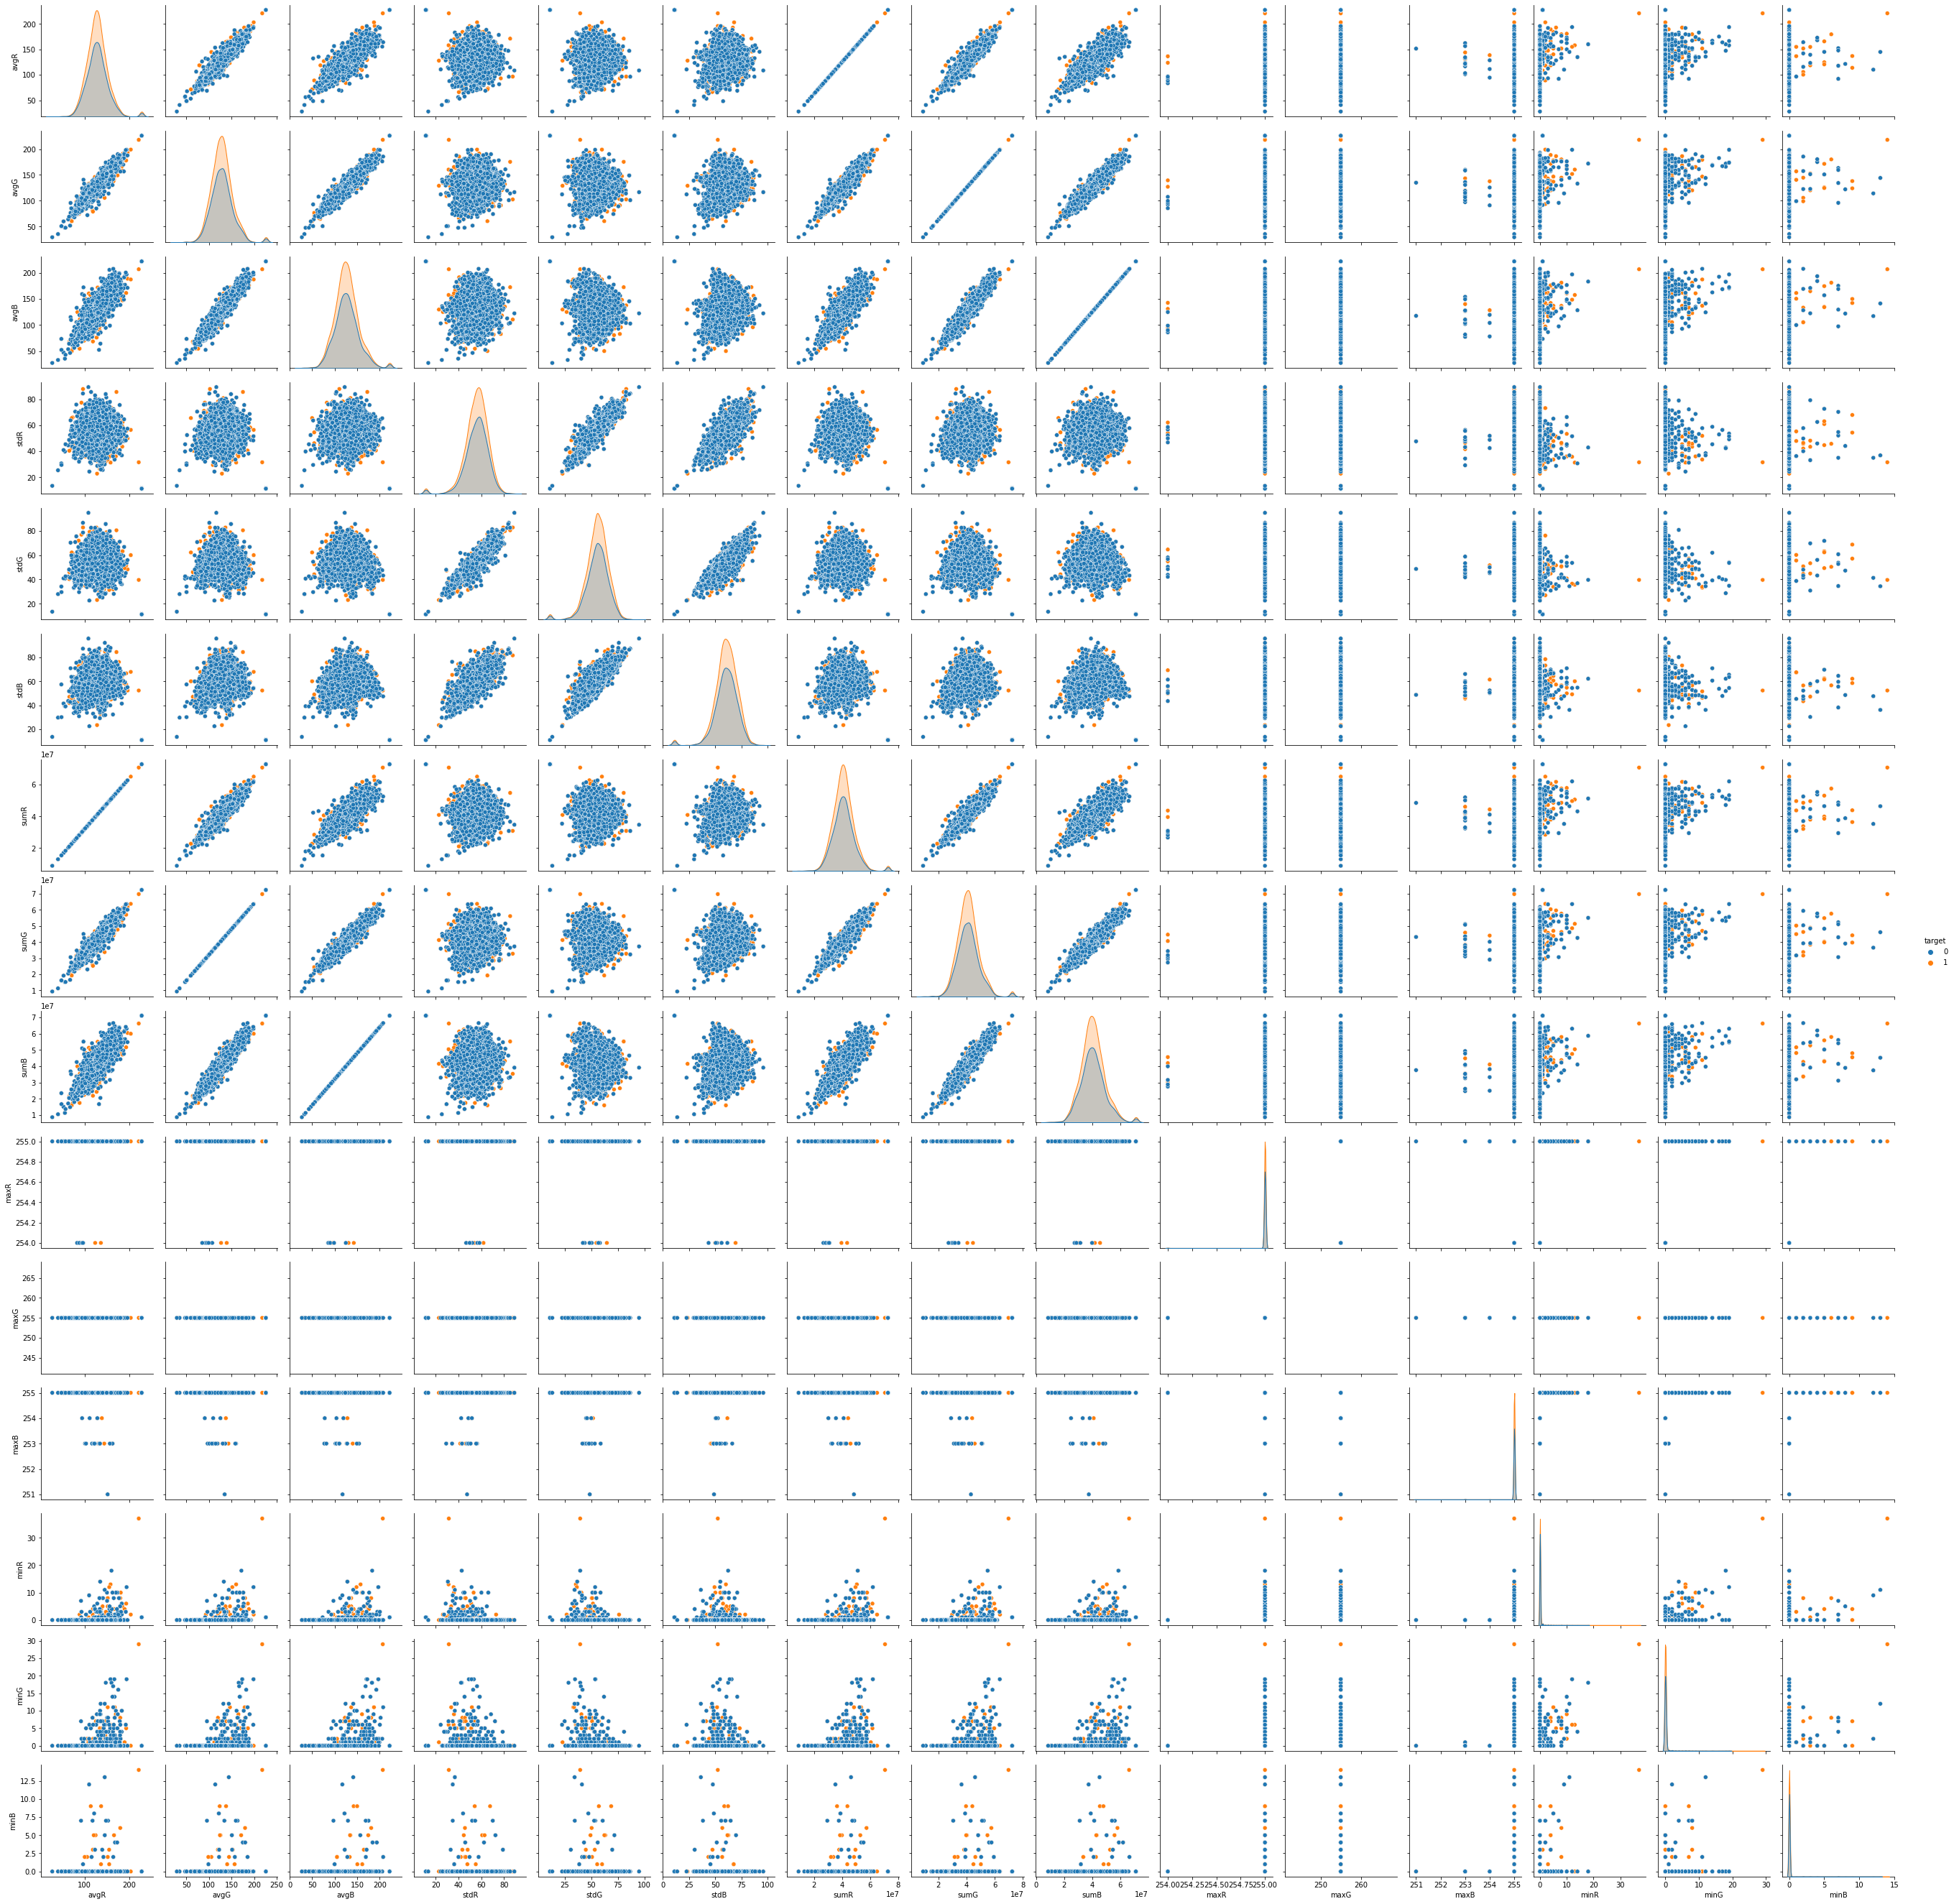

In [ ]:
sns.pairplot(df_final, hue='target')

In [83]:
df_final.describe()

,target,avgR,avgG,avgB,stdR,stdG,stdB,sumR,sumG,sumB,maxR,maxG,maxB,minR,minG,minB
count,11004.000000,7850.000000,7850.000000,7850.000000,7850.000000,7850.000000,7850.000000,7.850000e+03,7.850000e+03,7.850000e+03,7850.000000,7850.0,7850.000000,7850.000000,7850.000000,7850.000000
mean,0.413213,127.769820,128.564462,126.491192,55.842814,55.551344,60.268780,4.088634e+07,4.114063e+07,4.047718e+07,254.998089,255.0,254.992229,0.103949,0.165223,0.030701
std,0.492433,23.479682,23.942844,26.464657,9.937642,10.172760,10.533582,7.513498e+06,7.661710e+06,8.468690e+06,0.043674,0.0,0.128956,0.901943,1.225951,0.480953
min,0.000000,27.930728,28.991063,27.050253,11.221616,11.168040,11.045566,8.937833e+06,9.277140e+06,8.656081e+06,254.000000,255.0,251.000000,0.000000,0.000000,0.000000
25%,0.000000,113.152498,113.349388,109.923526,50.378830,49.978982,54.633505,3.620880e+07,3.627180e+07,3.517553e+07,255.000000,255.0,255.000000,0.000000,0.000000,0.000000
50%,0.000000,126.854647,127.503725,125.081156,56.628403,56.066053,60.673722,4.059349e+07,4.080119e+07,4.002597e+07,255.000000,255.0,255.000000,0.000000,0.000000,0.000000
75%,1.000000,140.545750,141.621650,141.338041,62.260873,62.006332,67.029150,4.497464e+07,4.531893e+07,4.522817e+07,255.000000,255.0,255.000000,0.000000,0.000000,0.000000
max,1.000000,227.129006,226.136734,222.152975,89.243558,94.956569,95.709420,7.268128e+07,7.236376e+07,7.108895e+07,255.000000,255.0,255.000000,37.000000,29.000000,14.000000


Correlação features x target

In [84]:
df_final.corr()

,target,avgR,avgG,avgB,stdR,stdG,stdB,sumR,sumG,sumB,maxR,maxG,maxB,minR,minG,minB
target,1.000000,-0.001145,-0.002678,-0.001387,0.001242,0.006436,0.008333,-0.001145,-0.002678,-0.001387,-0.001840,NaN,0.002668,0.007537,-0.003003,0.007729
avgR,-0.001145,1.000000,0.960541,0.877000,-0.166198,-0.176497,-0.077537,1.000000,0.960541,0.877000,0.057389,NaN,-0.004999,0.171764,0.147303,0.029462
avgG,-0.002678,0.960541,1.000000,0.957026,-0.144360,-0.179554,-0.039981,0.960541,1.000000,0.957026,0.050512,NaN,0.010163,0.169214,0.170484,0.040545
avgB,-0.001387,0.877000,0.957026,1.000000,-0.103129,-0.138113,0.002873,0.877000,0.957026,1.000000,0.041979,NaN,0.026811,0.149247,0.168207,0.052268
stdR,0.001242,-0.166198,-0.144360,-0.103129,1.000000,0.928423,0.811305,-0.166198,-0.144360,-0.103129,0.011667,NaN,0.057235,-0.168145,-0.093642,-0.046956
stdG,0.006436,-0.176497,-0.179554,-0.138113,0.928423,1.000000,0.890379,-0.176497,-0.179554,-0.138113,0.018449,NaN,0.045029,-0.160723,-0.130685,-0.042855
stdB,0.008333,-0.077537,-0.039981,0.002873,0.811305,0.890379,1.000000,-0.077537,-0.039981,0.002873,0.025432,NaN,0.043248,-0.108303,-0.066738,-0.050022
sumR,-0.001145,1.000000,0.960541,0.877000,-0.166198,-0.176497,-0.077537,1.000000,0.960541,0.877000,0.057389,NaN,-0.004999,0.171764,0.147303,0.029462
sumG,-0.002678,0.960541,1.000000,0.957026,-0.144360,-0.179554,-0.039981,0.960541,1.000000,0.957026,0.050512,NaN,0.010163,0.169214,0.170484,0.040545
sumB,-0.001387,0.877000,0.957026,1.000000,-0.103129,-0.138113,0.002873,0.877000,0.957026,1.000000,0.041979,NaN,0.026811,0.149247,0.168207,0.052268


Imagens ruído

Por observação, sabemos que a base possui imagens em branco classificadas como "Empresa". Desse modo, assumimos que estas imagens possuem caracteristicas RGB iguais e que ao calcularmos para todas as imagens podemos agrupá-las e removê-las

In [85]:
df_final['sum_features'] = df_final.drop(columns=['img_name', 'target']).sum(axis=1) / 255

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


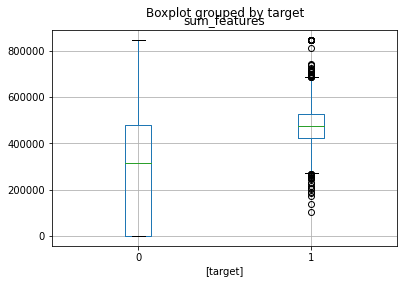

In [86]:
df_final[['target','sum_features']].boxplot(by='target')

Podemos simplesmente contar valors iguais de "sum_features" para identificarmos imagens repetidas ou com caracteristicas iguais

In [87]:
print('Exibindo TOP 20 sum_features mais frequentes')
df_final.groupby('sum_features').size().sort_values(ascending=False).reset_index(name='#').head(20)

Exibindo TOP 20 sum_features mais frequentes


,sum_features,#
0,0.000000,3154
1,847590.054329,81
2,321457.975558,13
3,539513.928160,7
4,400187.913062,6
5,376528.704395,6
6,498205.009644,5
7,368427.794630,5
8,532674.146689,4
9,497111.773778,4


In [89]:
sum_features_values = df_final.groupby('sum_features').size().sort_values(ascending=False).index.tolist()[:20]
sum_features_values

[0.0,
 847590.054329163,
 321457.9755584489,
 539513.928160221,
 400187.91306170536,
 376528.7043954326,
 498205.0096442565,
 368427.79462972225,
 532674.146689373,
 497111.77377765015,
 622676.8874674268,
 372422.3063134631,
 443210.86578933574,
 578650.5578676035,
 454667.25237045815,
 475664.7166705037,
 493622.7478031479,
 444249.42756965,
 588009.3801306522,
 447115.21234916727]

In [115]:
print('Exibindo TOP 20 sum_features mais frequentes')
for f_values in sum_features_values:
  result = df_final.loc[df_final['sum_features'] == f_values]
  print(' ###### ')
  print(' sum_features_values: ', f_values)
  print(' Número imagens: ', result.shape[0])
  print(' Exemplos (pode ser empresa ou não-empresa): ', str(result['img_name'].head(10).tolist()))
  print(' ###### ')

Exibindo TOP 20 sum_features mais frequentes
 ###### 
 sum_features_values:  0.0
 Número imagens:  3154
 Exemplos (pode ser empresa ou não-empresa):  ['1314.jpg', '1295.jpg', '1296.jpg', '1297.jpg', '1145.jpg', '1185.jpg', '1173.jpg', '1183.jpg', '1126.jpg', '1180.jpg']
 ###### 
 ###### 
 sum_features_values:  847590.054329163
 Número imagens:  81
 Exemplos (pode ser empresa ou não-empresa):  ['2585.jpg', '2265.jpg', '2258.jpg', '2210.jpg', '2221.jpg', '2211.jpg', '2218.jpg', '1882.jpg', '1876.jpg', '1838.jpg']
 ###### 
 ###### 
 sum_features_values:  321457.9755584489
 Número imagens:  13
 Exemplos (pode ser empresa ou não-empresa):  ['1747.jpg', '1659.jpg', '3797.jpg', '3536.jpg', '3537.jpg', '3564.jpg', '7869.jpg', '1747.jpg', '1659.jpg', '3564.jpg']
 ###### 
 ###### 
 sum_features_values:  539513.928160221
 Número imagens:  7
 Exemplos (pode ser empresa ou não-empresa):  ['2433.jpg', '6481.jpg', '5984.jpg', '7432.jpg', '6481.jpg', '5984.jpg', '7432.jpg']
 ###### 
 ###### 
 sum_feat